## Data Cleaning Stage

### Data reading

This notebook brings uses the scripts read_data_features.py and read_data_genre_track.py to arrive at a cleaned dataset with ready to use features and labels.

The following is 'read_data_genre_track.py'. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

#matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [3]:
metadata_path = '..\\Dataset\\fma_metadata'

In [4]:
## Read genre information
genres = pd.read_csv(metadata_path+'\\genres.csv')

In [5]:
genre_grps = genres.groupby('parent')


In [6]:
genre_id_root = genre_grps.get_group(0)['genre_id'] # Extract the parent groups
genre_id_name = genre_grps.get_group(0)['title']
main_label_dict = dict(zip(list(genre_id_root),list(genre_id_name)))

In [7]:
main_label_dict

{2: 'International',
 3: 'Blues',
 4: 'Jazz',
 5: 'Classical',
 8: 'Old-Time / Historic',
 9: 'Country',
 10: 'Pop',
 12: 'Rock',
 13: 'Easy Listening',
 14: 'Soul-RnB',
 15: 'Electronic',
 17: 'Folk',
 20: 'Spoken',
 21: 'Hip-Hop',
 38: 'Experimental',
 1235: 'Instrumental'}

In [8]:
## Read track information
fields = ['track']
tracks = pd.read_csv(metadata_path+'\\tracks_mod.csv',nrows=85000)
tracks.head()

,track_id,genres,genres_all
0,2,[21],[21]
1,3,[21],[21]
2,5,[21],[21]
3,10,[10],[10]
4,20,"[76, 103]","[17, 10, 76, 103]"


In [9]:
tracks = tracks.dropna()

In [10]:
tgen = list(tracks['genres'])
#print(tgen)

In [11]:
tgen = [t.replace('[','') for t in tgen]
tgen = [t.replace(']','') for t in tgen]
tgen = [t.replace(' ','') for t in tgen]
#print(tgen)

In [12]:
for k in range(len(tgen)):
    if(len(tgen[k])!=0):
        tgen[k] = [i for i in map(int, tgen[k].split(','))]
    else:
        tgen[k]=[]
#print(tgen)

In [13]:
tracks['genres']=tgen

In [14]:
tracks.head()

,track_id,genres,genres_all
0,2,[21],[21]
1,3,[21],[21]
2,5,[21],[21]
3,10,[10],[10]
4,20,"[76, 103]","[17, 10, 76, 103]"


In [15]:
print(len(tgen))
#print(tracks.index)

84991


### Extracting relevant tracks and labels

In [16]:
## Match the tracks to the genre data: Create dictionary with genre label as key
genre_dict = {}
for i in range(len(tgen)): # for every track (tgen is a list of lists of genres corresponding to every track)
    if i in tracks.index:  
        ti = tracks['track_id'][i] # ti stores the track id corresponding to the index
        if 1<=len(tgen[i])<=1: # new condition that checks if t has just one genre and only then proceeds
            for k in tgen[i]: # k iterates through list of genres of current track
                if k is not None:
                    if (k in genre_dict.keys()): # if new genre is in the keys of genre_dict
                        genre_dict[k]+=[ti] # append current track id to list of all track ids
                    else:
                        genre_dict.update({k:[ti]}) # if k is a new key, then add new element to dictionary with ti as value

In [17]:
genre_dict[4][0]

144

In [18]:
## Total number of samples for the different root genres
for q in genre_id_root:
    print(q,len(genre_dict[q]))

2 119
3 101
4 320
5 731
8 543
9 16
10 505
12 1717
13 3
14 15
15 2221
17 1205
20 17
21 2363
38 1233
1235 199


Based on the above, the genres with sufficient data is selected for training.

In [19]:
#genre_set = [4,5,8,10,12,15,17,21,38]
#genre_set = [17,15,12,21,38]
#genre_set = [8,5,12,15,17,21,38]
genre_set = [4,5,10,12,15,17,21]
#genre_set = [5,10,12,15,17,21]
#genre_set = [10,5,12,15,17,21,38]


The code below selects the unique selection of 932 tracks from this list, with no repetitionof tracks

In [20]:
track_list = genre_dict[genre_set[0]]
label_list = [genre_set[0]]*len(track_list)
for k in genre_set[1:]:
    t1 = genre_dict[k]
    while len(t1)>0:
        t2 = t1.pop()
        track_list.append(t2)
        label_list.append(k)
                    
len(set(track_list))/len(genre_set)

1294.5714285714287

In [21]:
num_tracks = len(track_list)
num_tracks

9062

In [22]:
tr_len = 8062 # Training length per class
test_len = 1000 # Testing length per class

Now we create the corresponding list of labels for this list.

### Feature extraction for the relevant track ids

The following is 'read_data_features.py'.

In [23]:
## Column information
fields = ['mfcc.40','mfcc.42','mfcc.43','mfcc.44','mfcc.45','mfcc.48','mfcc.49','mfcc.50',\
    'mfcc.53','mfcc.56','mfcc.120','mfcc.121','mfcc.122','mfcc.124','spectral_contrast.14',\
        'spectral_contrast.15','spectral_contrast.16','spectral_contrast.43',\
            'spectral_contrast.44','feature']


In [24]:
## Read feature information 
features = pd.read_csv(metadata_path+'\\features.csv',usecols=fields)

G:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,293,295,296,297,298,301,302,303,306,309,373,374,375,377,428,429,430,457,458) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
features['feature'][3:] = features['feature'][3:].astype(int)

In [26]:
feat_all = features.loc[features['feature'].isin(track_list)]

In [27]:
feat_all.shape

(9062, 20)

In [28]:
len(label_list)

9062

In [29]:
feat_all['label'] = label_list

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Shuffle the order of the data

In [30]:
feat_all = feat_all.sample(frac=1)

Create separate numpy arrays and convert to type float

In [31]:
feat_all = feat_all.to_numpy()
tr_features = feat_all[0:tr_len,1:-1]
tr_features = tr_features.astype(float)
test_features = feat_all[tr_len:tr_len+test_len,1:-1]
test_features = test_features.astype(float)

In [32]:
tr_features.shape

(8062, 19)

In [33]:
test_features.shape

(1000, 19)

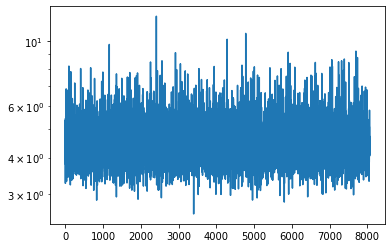

In [34]:
plt.semilogy(tr_features[:,-1])

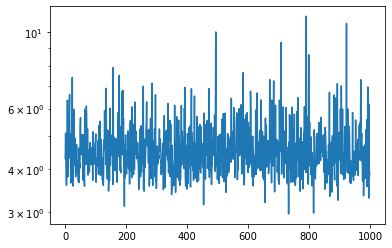

In [35]:
plt.semilogy(test_features[:,-1])

In [36]:
len(set(test_features[:,-1]))

999

### To obtain set of one hot codes for our labels

In [37]:
feat_tr = feat_all[0:tr_len,1:]
feat_test = feat_all[tr_len:tr_len+test_len,1:]

In [38]:
feat_test[:,-1] = [genre_set.index(w) for w in feat_test[:,-1]]
feat_tr[:,-1] = [genre_set.index(w) for w in feat_tr[:,-1]]

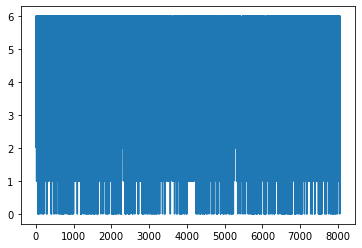

In [39]:
plt.plot(feat_tr[:,-1])

In [40]:
num_classes = len(genre_set)
one_hot = np.zeros((num_classes, num_classes*tr_len))
print(one_hot.shape)
for index_i, i in enumerate(feat_tr[:,-1]):
    one_hot[int(i),index_i] = 1


(7, 56434)


In [41]:
feat_tr[0:10,-1]

array([3, 6, 6, 3, 4, 5, 3, 6, 6, 3], dtype=object)

In [42]:
print(one_hot[:,0:10])
print(one_hot.shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1. 1. 0.]]
(7, 56434)


## Training Stage

### Setting up data 

In [43]:
x_train = tr_features/1000
x_test = test_features/1000
y_train = feat_tr[:,-1]
y_test = feat_test[:,-1]

In [44]:
class_set = list(range(num_classes))
class_lbl = [genre_set[i] for i in class_set]
class_name = [main_label_dict[genre_set[i]] for i in class_set]
label_dict = dict(zip(class_name,class_set))

In [45]:
label_dict

{'Jazz': 0,
 'Classical': 1,
 'Pop': 2,
 'Rock': 3,
 'Electronic': 4,
 'Folk': 5,
 'Hip-Hop': 6}

In [46]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize=(8,8))
    plt.subplots()
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    
    ax = plt.gca();

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.gcf().subplots_adjust(bottom=0.15)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels1 = np.zeros((num_records, num_classes))
    #print(true_labels.shape)
    for index_i, i in enumerate(true_labels):
        #print(index_i,i)
        true_labels1[index_i,int(i)] = 1
    return true_labels1

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    #print(pred)
    one_hot_true = one_hot_encoder(y_test, len(pred), num_classes)
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

### Boosting

In [47]:
%%time
# Train

xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.01, objective='multi:softprob', \
                                   n_estimators=350, sub_sample = 0.9, num_class = num_classes)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)


Wall time: 26 s


In [48]:
pred = np.argmax(pred_probs, axis=-1)
print('Test Error: ',len(y_test[y_test!=pred])/len(y_test))

Test Error:  0.629


Test Set Accuracy =  0.37
Test Set F-score =  0.28
ROC AUC = 0.688
Confusion matrix, without normalization
[[  2   1   0   7   9   0  18]
 [  0  13   5   6  15   2  41]
 [  1   2  11   8  10   0  18]
 [  1   3   2  67  34   3  98]
 [  0   4   1  30  94   2 117]
 [  2   5   2  15  21   6  75]
 [  0   4   0  23  42   2 178]]


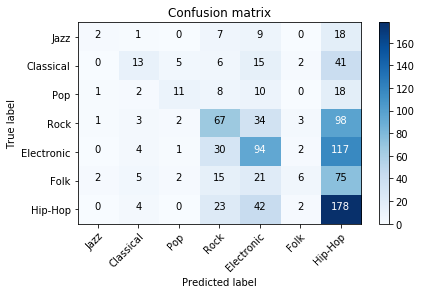

In [49]:
display_results(np.array(y_test,dtype=int), pred_probs)

### SVM 

In [50]:
cl_weight = dict(pd.Series(np.array(y_train,dtype=int)).value_counts(normalize=True))

In [51]:
cl_weight

{6: 0.2622178119573307,
 4: 0.244728355246837,
 3: 0.18717439841230463,
 5: 0.13383775738030265,
 1: 0.08050111634830066,
 2: 0.056437608533862565,
 0: 0.03510295212106177}

In [52]:
%%time

# Train
svm_classifier = SVC(C=10000.0, probability = True, class_weight=cl_weight)
svm_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

G:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 41.2 s


In [53]:
pred = np.argmax(pred_probs, axis=-1)
print('Test Error: ',len(y_test[y_test!=pred])/len(y_test))

Test Error:  0.696


Test Set Accuracy =  0.30
Test Set F-score =  0.15
ROC AUC = 0.637
Confusion matrix, without normalization
[[  0   0   0   0  10   0  27]
 [  0   6   0   3  18   0  55]
 [  0   1   0   4  19   0  26]
 [  0   1   0  12  56   1 138]
 [  0   1   0  10  97   0 140]
 [  0   2   0   4  37   1  82]
 [  0   0   0  10  49   2 188]]


G:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


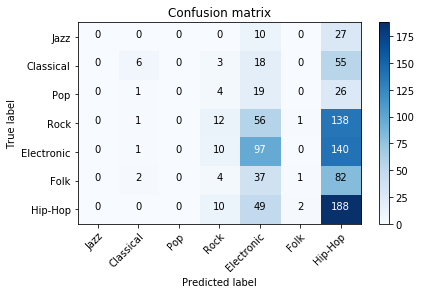

In [54]:
display_results(np.array(y_test,dtype=int), pred_probs)

### Random Forest

In [55]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

Wall time: 12.1 s


Test Set Accuracy =  0.43
Test Set F-score =  0.37
ROC AUC = 0.758
Confusion matrix, without normalization
[[  6   1   0   8   5   0  17]
 [  0  18   2   8  15   0  39]
 [  0   2  12   4   8   1  23]
 [  0   3   0  74  42   2  87]
 [  0   2   2  23 129   4  88]
 [  0   8   0  10  24  18  66]
 [  1   0   1  24  44   1 178]]


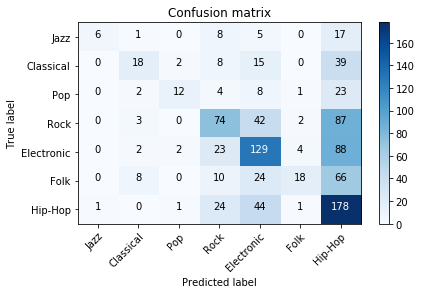

In [56]:
# Results
display_results(np.array(y_test,dtype=int), pred_probs)

### Logistic Regression

In [57]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l1')
lr_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

Wall time: 172 ms


G:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
G:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Test Set Accuracy =  0.27
Test Set F-score =  0.11
ROC AUC = 0.592
Confusion matrix, without normalization
[[  0   0   0   0  15   0  22]
 [  0   1   0   0  26   0  55]
 [  0   0   0   0  21   0  29]
 [  0   1   0   0  91   0 116]
 [  0   0   0   0 102   0 146]
 [  0   0   0   0  46   0  80]
 [  0   1   0   1  76   0 171]]


G:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


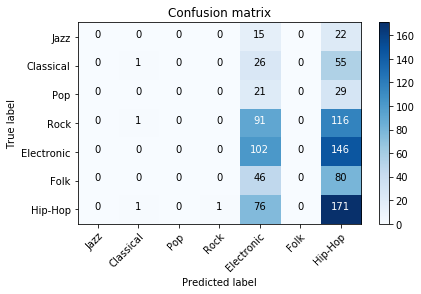

In [58]:
# Results
display_results(np.array(y_test,dtype=int), pred_probs)